# Step 1: import necessary packages and data

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import shapiro
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import explained_variance_score, r2_score, mean_absolute_error, mean_squared_error
import xgboost
from xgboost import XGBRegressor, plot_importance

from collections import Counter


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Step 2: get high-level insights into data


In [3]:
Data = pd.read_csv('Mileage.csv')
Data.columns=['mpg','cylinders','displacement','horsepower','weight','acceleration','model year','origin','car name']

Data.replace({'?':np.nan},inplace=True)

Data['horsepower'] = pd.to_numeric(Data['horsepower'])
Data.dtypes ## Confirmed that horsepower is object, so change to numeric

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

In [5]:
Data.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


### Take-away from above: there are 398 cars in this dataset, with set numbers of cylinders and set model years, set origin. mpg is target variable and is continuous, as are displacement, weight, acceleration
### Car names are strings, so not on here.

### Regression appears the best approach, with some features potentially needing encoding.

## Step 2a) Seaborn heatmap to understand how different variables impact final predicted mpg

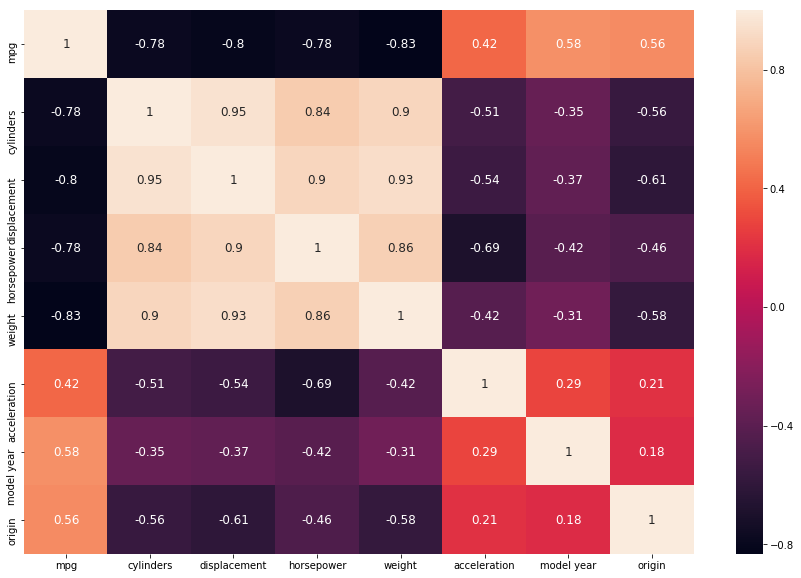

In [6]:
plt.figure(figsize=(15,10))
sns.heatmap(Data.corr(),annot=True,annot_kws={"size":12})



### Conclusions from above:

### (1) Car weight and displacement have the strongest correlation: the heavier the weight and higher displacement, the lower mpg
### (2) Car horsepower and cylider number are also strongly correlated with mpg: more HP and more cylinders, less mpg
### (3) Less impactful: car origin, model year, acceleration. 

### Rule of thumb: threshold correlation coefficient for inclusion of feature is 0.6, sometimes as high as 0.7. Suggest dropping acceleration at minimum, and potentially origin, model year too

## Step 2b) Using barplots to better understand distribution of categorical features

(array([57., 28., 40., 27., 30., 62., 36., 29., 29., 60.]),
 array([70. , 71.2, 72.4, 73.6, 74.8, 76. , 77.2, 78.4, 79.6, 80.8, 82. ]),
 <a list of 10 Patch objects>)

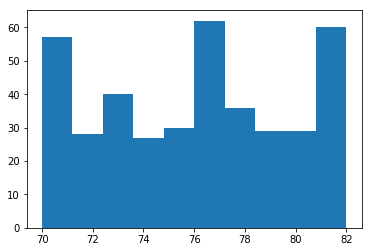

In [7]:
plt.hist(Data['model year'],histtype='bar')

(array([249.,   0.,   0.,   0.,   0.,  70.,   0.,   0.,   0.,  79.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

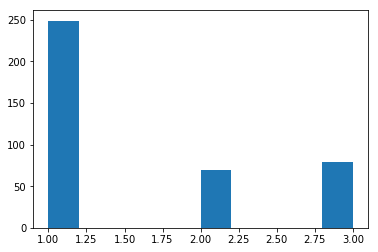

In [8]:
plt.hist(Data['origin'],histtype='bar')

(array([13., 78., 73., 61., 54., 48., 38., 22.,  5.,  6.]),
 array([ 9.  , 12.76, 16.52, 20.28, 24.04, 27.8 , 31.56, 35.32, 39.08,
        42.84, 46.6 ]),
 <a list of 10 Patch objects>)

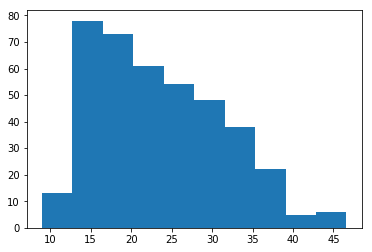

In [9]:
plt.hist(Data['mpg'],histtype='bar')


### Conclusions from above: 

### - mpg is skewed right, suggesting potential need for log transform
### - categorical numerical variables increase with mpg, so simple encoding should suffice - not ordinal



## Step 2c) Using boxplots to search for possible outliers

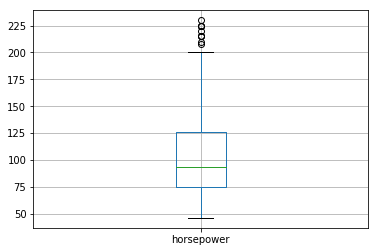

In [10]:
Data.boxplot(column=['horsepower'])

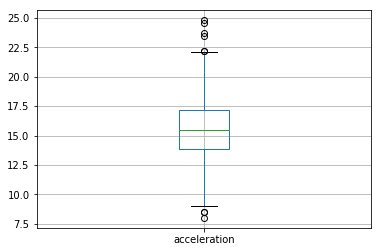

In [12]:
Data.boxplot(column=['acceleration'])


## Step 3) Prepare dataset before training model on data by encoding and removing outliers

### First create function to remove outliers, then apply:

In [14]:
# Outlier detection - courtesy of Yassine's https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 2 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers  

In [15]:
drop = detect_outliers(Data,0,['mpg','cylinders','displacement','horsepower','weight','acceleration'])
Data = Data.drop(drop, axis = 0).reset_index(drop=True)

### Encoding categorical variables and imputing missing values in horsepower

In [16]:
# cols=['cylinders','model year','origin']
# Data[cols] = Data[cols].astype('str')

Data['car make'] = Data['car name']
Data['car make'] = Data['car name'].apply(lambda x: x.split()[0]) 

Data.drop(columns=['car name'],inplace=True)



Data = pd.get_dummies(Data,columns=['car make'])

Data['mpg'] = np.log(1 + 100*Data['mpg'])

x_no_log = Data.drop(columns=['mpg'])
y_no_log = Data['mpg']

imp = SimpleImputer(missing_values=np.nan,strategy='median')
x_no_log['horsepower'] = imp.fit(x_no_log['horsepower'].values.reshape(-1, 1)).transform(x_no_log['horsepower'].values.reshape(-1, 1))



### Create testing and training datasets

In [18]:
xtrain,xtest,ytrain,ytest = train_test_split(x_no_log,y_no_log, test_size=0.3, random_state=42)

## Step 4) Creating instances of RandomForest and XGBoost, then setting up the hyperparameter grid for use in GridSearchCV

In [21]:
rf = RandomForestRegressor()
xgbr = XGBRegressor()

In [22]:
rf_param_grid = {"max_depth": [None],
              "max_features": [5, 10, 20],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300]}

In [23]:
kfold = KFold(n_splits=10)
gsRFC_all = GridSearchCV(rf,param_grid = rf_param_grid, cv=7, scoring="neg_mean_squared_error", n_jobs= 4, verbose = 1)
gsRFC_all.fit(xtrain,ytrain)

RandForest_best = gsRFC_all.best_estimator_

# Best score
gsRFC_all.best_score_

Fitting 7 folds for each of 54 candidates, totalling 378 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done 378 out of 378 | elapsed:  1.1min finished


-0.012746250810079391

In [24]:
xgb_params = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500,1000]}

gsXGB = GridSearchCV(xgbr, xgb_params, cv = 7, scoring='neg_mean_squared_error', 
                     refit=True, n_jobs = 5, verbose=True)
gsXGB.fit(xtrain,ytrain)

XGB_best = gsXGB.best_estimator_

gsXGB.best_score_


Fitting 7 folds for each of 18 candidates, totalling 126 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   31.5s
[Parallel(n_jobs=5)]: Done 126 out of 126 | elapsed:  1.5min finished


-0.011394962522029409

In [25]:
ypred = XGB_best.predict(xtest)
explained_variance_score(ytest,ypred)
mean_absolute_error(ytest,ypred)
mean_squared_error(ytest,ypred,squared=True)

0.011778599851403185

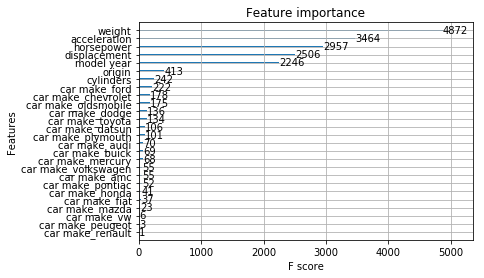

In [32]:
plot_importance(XGB_best)

In [26]:
ypred_alt = RandForest_best.predict(xtest)
explained_variance_score(ypred_alt,ytest)
mean_absolute_error(ytest,ypred_alt)
mean_squared_error(ytest,ypred_alt,squared=True)

0.011822046827581265

## Step 5) Implementing PyTorch neural network to train on mpg dataset for predicting

In [33]:
import torch
from torch import nn

In [34]:
# Define network dimensions
n_input_dim = xtrain.shape[1]
# Layer size
n_hidden = 4 # Number of hidden nodes
n_output = 1 # Number of output nodes for predicted mpg

# Build mdel
torch_model = torch.nn.Sequential(
    torch.nn.Linear(n_input_dim, n_hidden),
    torch.nn.ELU(),
    torch.nn.Linear(n_hidden, n_output)
)
    
print(torch_model)

Sequential(
  (0): Linear(in_features=44, out_features=4, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=4, out_features=1, bias=True)
)


In [35]:
loss_func = torch.nn.MSELoss() #Choosing mean square error as loss metric
learning_rate = 0.01
optimizer = torch.optim.Adam(torch_model.parameters(), lr=learning_rate)

Text(0.5, 1.0, 'Training Loss')

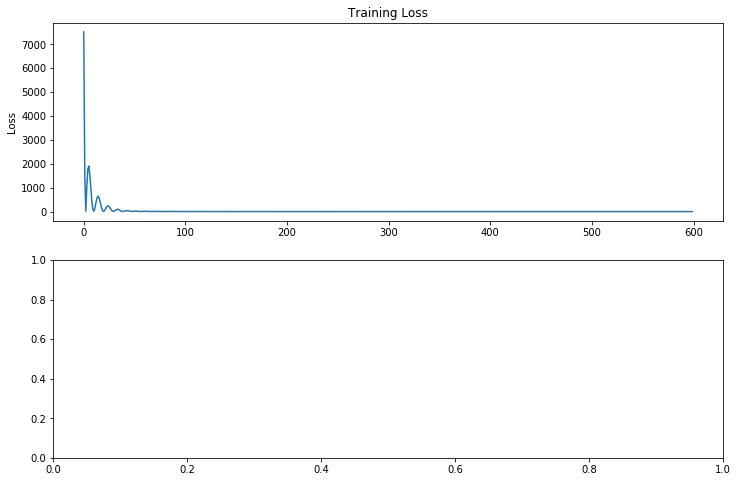

In [36]:
train_error = []
iters = 600

Y_train_t = torch.FloatTensor(ytrain.values).reshape(-1,1) #Converting numpy array to torch tensor

for i in range(iters):
    X_train_t = torch.FloatTensor(xtrain.values)  #Converting numpy array to torch tensor
    y_hat = torch_model(X_train_t)
    loss = loss_func(y_hat, Y_train_t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_error.append(loss.item())
    
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_error)
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

In [37]:
X_test_t = torch.FloatTensor(xtest.values)
ypredict = torch_model(X_test_t)
mean_squared_error(ytest,ypredict.detach().numpy(),squared=True)

0.10776058366808337